# 下载数据

In [5]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"


In [ ]:
# 加载数据
def fetch_housing_data(housing_url = HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path,"housing_tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

# 加载数据

In [6]:
import pandas as pd 

def load_housing_data(housing_path=HOUSING_PATH):
    cvs_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(cvs_path)

In [7]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### 数据整体信息

In [9]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [10]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [11]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### 画出每个属性的柱状图

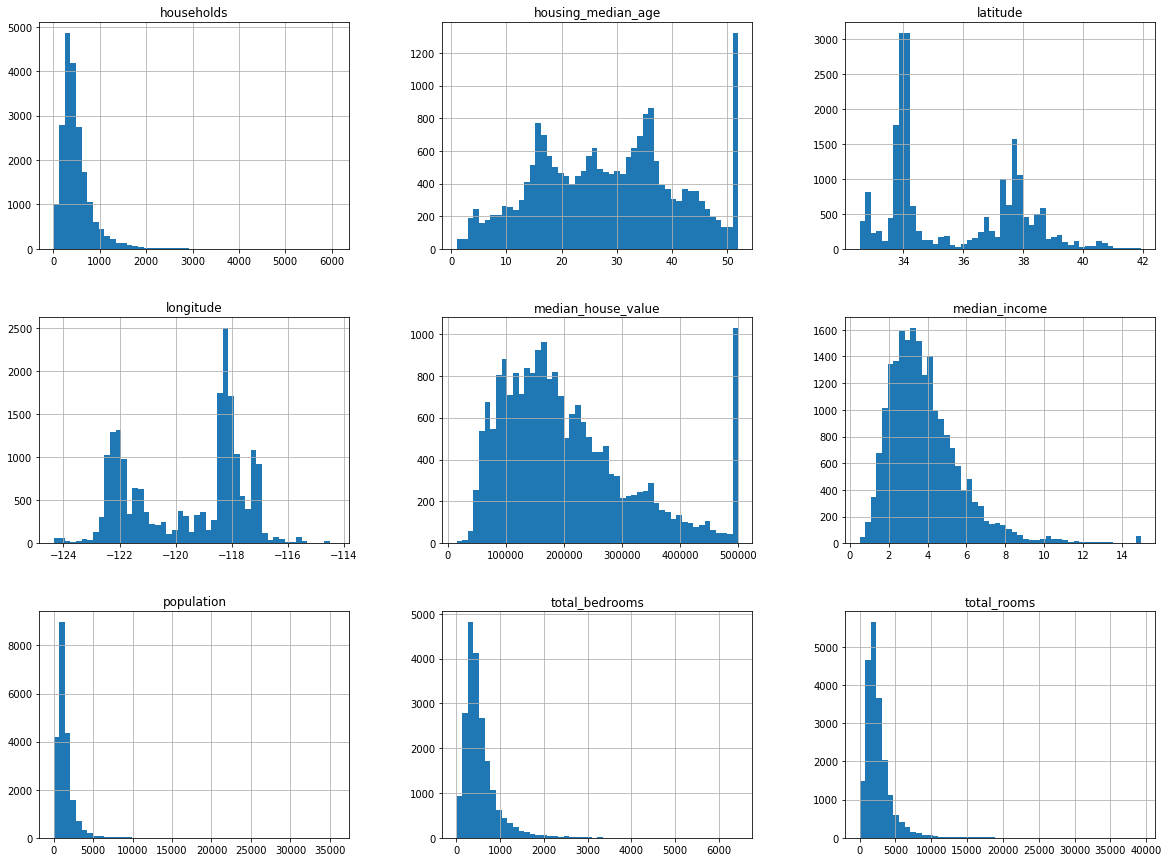

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt 
housing.hist(bins=50,figsize=(20,15))
plt.show()

## 创建测试集

In [10]:
import numpy as np

#此方法可行，但是不完美，如果再次运行，就会长生一个不同的测试集，多次运行后
#就会得到整个数据集，这是需要避免的。

def split_train_test(data,test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set),"train+",len(test_set),"test")

16512 train+ 4128 test


### 解决办法
1. 保存第一次运行得到的测试集，并在随后过程加载。
2. 在调用np.random.permutation之前，设置随机数生成器种子，以产生总是相同的洗牌指数。
但是如果数据更新，两个方法都会失效。

一个通常解决办法是使用每个实例的ID来判定这个实例是否应该加入测试集。

In [12]:
import hashlib

def test_set_check(identifier,test_radio,hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_radio

def split_train_test_by_id(data,test_radio,id_column,hsah=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:test_set_check(id_,test_radio,hash))
    return data.loc[~in_test_set],data.loc[in_test_set]

In [14]:
# housing_with_id = housing.reset_index()

# train_set, test_set = split_train_test_by_id(housing_with_id,0.2,"index")

### sklearn数据分割
train_test_split方法，random_state参数，可以设定随机生成器种子；可以将种子传递给多个行数相同的数据集，可在相同索引上分割数据集。

In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing,
                                       test_size=0.2,
                                       random_state=42)

将收入中位数除以1.5，创建一个收入类别属性，用ceil对值舍入，然后将所有大于5的分类归入到分类5。

In [16]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"]<5,5.0,inplace=True)


In [17]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0


根据收入分类，分层采样。

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,
                              test_size=0.2,
                              random_state=42)

for train_index, test_index in split.split(housing,housing["income_cat"]):
    
    print("train_index:",train_index)
    print("test_index:",test_index)
    stract_train_set = housing.loc[train_index]
    stract_test_set = housing.loc[test_index]

train_index: [17606 18632 14650 ... 13908 11159 15775]
test_index: [ 5241 10970 20351 ...  4019 12107  2398]


检查结果

In [25]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

### 删除incom_cat属性，使数据回到初始状态：

In [26]:
for set in (stract_train_set,stract_test_set):
    set.drop(["income_cat"],axis=1,inplace=True)

# 数据探索和可视化、发现规律